In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import r1svd as r1
from sklearn.manifold import TSNE, LocallyLinearEmbedding, Isomap
from sklearn.decomposition import PCA
import imblearn.combine as imc
import imblearn.over_sampling as imos
import imblearn.under_sampling as imus
import joblib
from sklearn.preprocessing import StandardScaler
from umap import UMAP
from collections import Counter
from scipy.cluster import hierarchy
from sklearn.metrics import precision_recall_curve, auc , f1_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

Using TensorFlow backend.


# Les données

In [2]:
creditcard = pd.read_csv("./input/creditcard.csv",sep=",")
creditcard.shape

(284807, 31)

In [3]:
# affichage de quelque valeur du jeux de données
creditcard.iloc[:5, :5]

,Time,V1,V2,V3,V4
0,0.0,-1.359807,-0.072781,2.536347,1.378155
1,0.0,1.191857,0.266151,0.166480,0.448154
2,1.0,-1.358354,-1.340163,1.773209,0.379780
3,1.0,-0.966272,-0.185226,1.792993,-0.863291
4,2.0,-1.158233,0.877737,1.548718,0.403034


## Description du jeu de données

Le jeu de données contient les transactions effectuées par cartes de crédit en septembre 2013 par les titulaires de carte européennes. Cet ensemble de données présente les transactions qui se sont produites en deux jours, où nous avons 492 fraudes sur 284 807 transactions. L'ensemble de données est très déséquilibré, les classes positives (fraudes) représentent 0,172% de toutes les transactions.
Mise à part les variable Amount, Time et Class(la variable cible) les autres variables contiennent uniquement d'entrées numériques résultant d'une transformation PCA. L’ensemble du jeu de  données contient au total 31 variables et 284 807 observation.

1. Les variable V1, V2, ... V28 sont les composantes principales obtenues avec PCA
2. La variable Time contient les secondes écoulées entre chaque transaction et la première transaction de l'ensemble de données
3. La variable Amount est le montant de la transaction, cette caractéristique peut être utilisée pour l'apprentissage sensible aux coûts dépendant de l'exemple
4. La variable Class est la variable réponse et prend 1 en cas de fraude et 0 sinon 

# Exploration des données

In [3]:
def targetOverview(data):
    class_dist = data.Class.value_counts()
    print(class_dist)
    percent_nf = (class_dist[0] / (class_dist[0] + class_dist[1])) * 100
    percent_f = (class_dist[1] / (class_dist[0] + class_dist[1])) * 100
    print("pourcentage de class avec non-fraud :", round(percent_nf,2),"%")
    print("pourcentage de class avec fraud :",  round(percent_f,2),"%")
    plt.figure(figsize=(8,5))
    plt.bar([2,4],class_dist,tick_label=["No fraud","fraud"], color=["green", "red"], width=0.5)
    plt.ylabel('nombre de transaction') 
    plt.xlabel('classe') 
    plt.title('Distribution de fraude et non fraude',fontsize=17)
    plt.savefig('./output/target_dis.png') 
    plt.show()

### La variable cible (Class)
Comme décrit dans la partie description du jeu de données on peut voir sur la figure distribution des fraude et non fraud que la classe fraud représente environ 0.2% du jeu de données. Avec cette distribution des deux class un modèle de classification qui prédit toujours non fraude pourra faire un bon score sachant que l'algorithme n'est pas efficace pour ce contexte de classification.

0    284315
1       492
Name: Class, dtype: int64
pourcentage de class avec non-fraud : 99.83 %
pourcentage de class avec fraud : 0.17 %


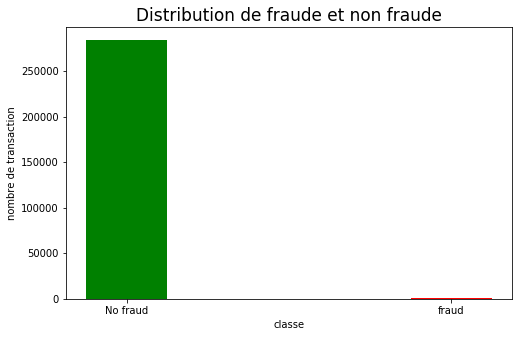

In [4]:
creaditcard = StandardScaler().fit(creditcard).transform(creditcard)
targetOverview(creditcard)

In [26]:
def plot_hist(data):
    coln = data.columns.drop("Class")
    plt.figure(figsize=(17,57))
    for index,cl in enumerate(coln):
        ax = plt.subplot(11,3,index + 1)
        ax.set_xlabel(cl)
        ax.set_ylabel('Nombre de transaction') 
        ax.set_title('Distribution du '+ cl +' des transactions', fontsize=14)
        sns.distplot(data.loc[:,cl],bins=20,kde=False,ax=ax)
    plt.savefig('./output/var_distrib.png')    
    plt.show()

## La distribution des variable

Sur la figure de distribution des variables on peut voir que la majorité des transactions ont eux lieu entre 25000 et 80000 ou 115000 et 170000 secondes après la première transaction. les variables v4, v9, v11, v12,13, v14, v15, v16, v18, v19, v24,26 ont une distribution proche de celle d'une loi normale centre réduit tandis que les autres variables sont plus contant autour de 0.
On a egalement constater que 27 des transactions frauduleuse on des montant egal a zero, les transactions frauduleuses ont coute au minimum 0 et au maximum 2.125,87, le montant total des transactions frauduleuse est 60.127,97 environ contre 25.162.590,01 entviron soit 0,00239% de perte sur le montant total.

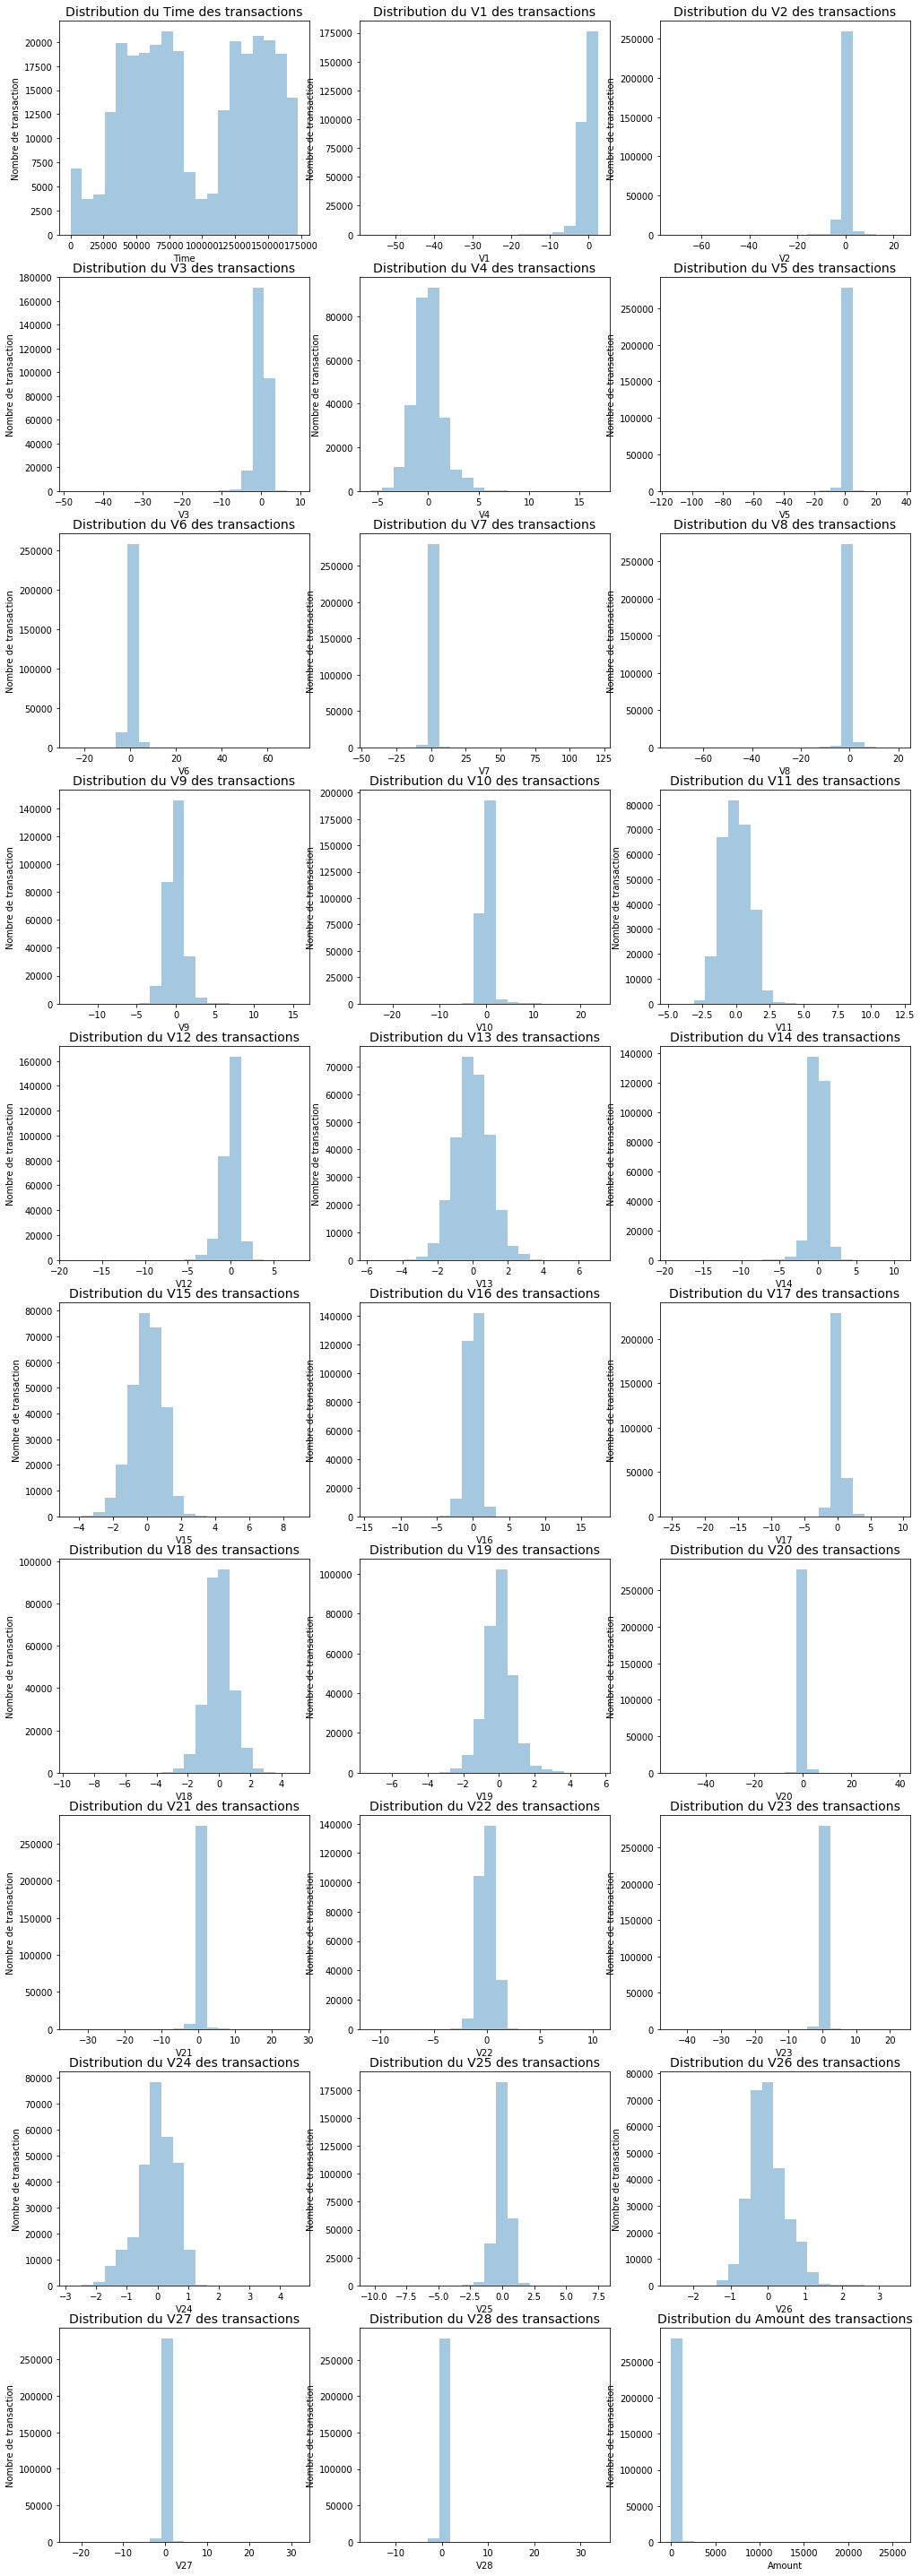

In [27]:
plot_hist(creditcard)

In [24]:
amount = creditcard[creditcard.Class == 1]['Amount']
print(max(amount))
print(min(amount))
print(len(sorted(amount[amount == 0.0])))
print(sum(amount))
print(sum(creditcard.Amount))
print("pourcentage de perte par rapport au montant total des transaction:",  round(sum(amount)/sum(creditcard.Amount),5),"%")

2125.87
0.0
27
60127.96999999997
25162590.009983554
pourcentage de perte par rapport au montant total des transaction: 0.00239 %


In [29]:
def box_plot(data):
    coln = data.columns.drop("Class")
    plt.figure(figsize=(17,47))
    for index,cl in enumerate(coln):
        ax = plt.subplot(11,3,index + 1)
#         ax.set_xlabel(cl)
        ax.set_ylabel('Nombre de transaction') 
        ax.set_title( cl +' vs Class positive et negative', fontsize=10)
        sns.boxplot(data=data,x='Class',y=cl,ax=ax)
    plt.savefig('./output/bar_.png')    
    plt.show()

## Le Boxplot des autres variables par rapport a la variable cible `Class`

Cette boxplot des differents variables avec la variable Class nous permet de voir que la pluspart des variables contient des outliers et que les variable on en moyenne leur valeur proche de zero. on peut aussi voir que l'existance d'une transaction frauduleuse n'est pas lie au temps de la transaction car le box plot du time selon la classe fraud et la classe non fraud sont a peu pres similaire.

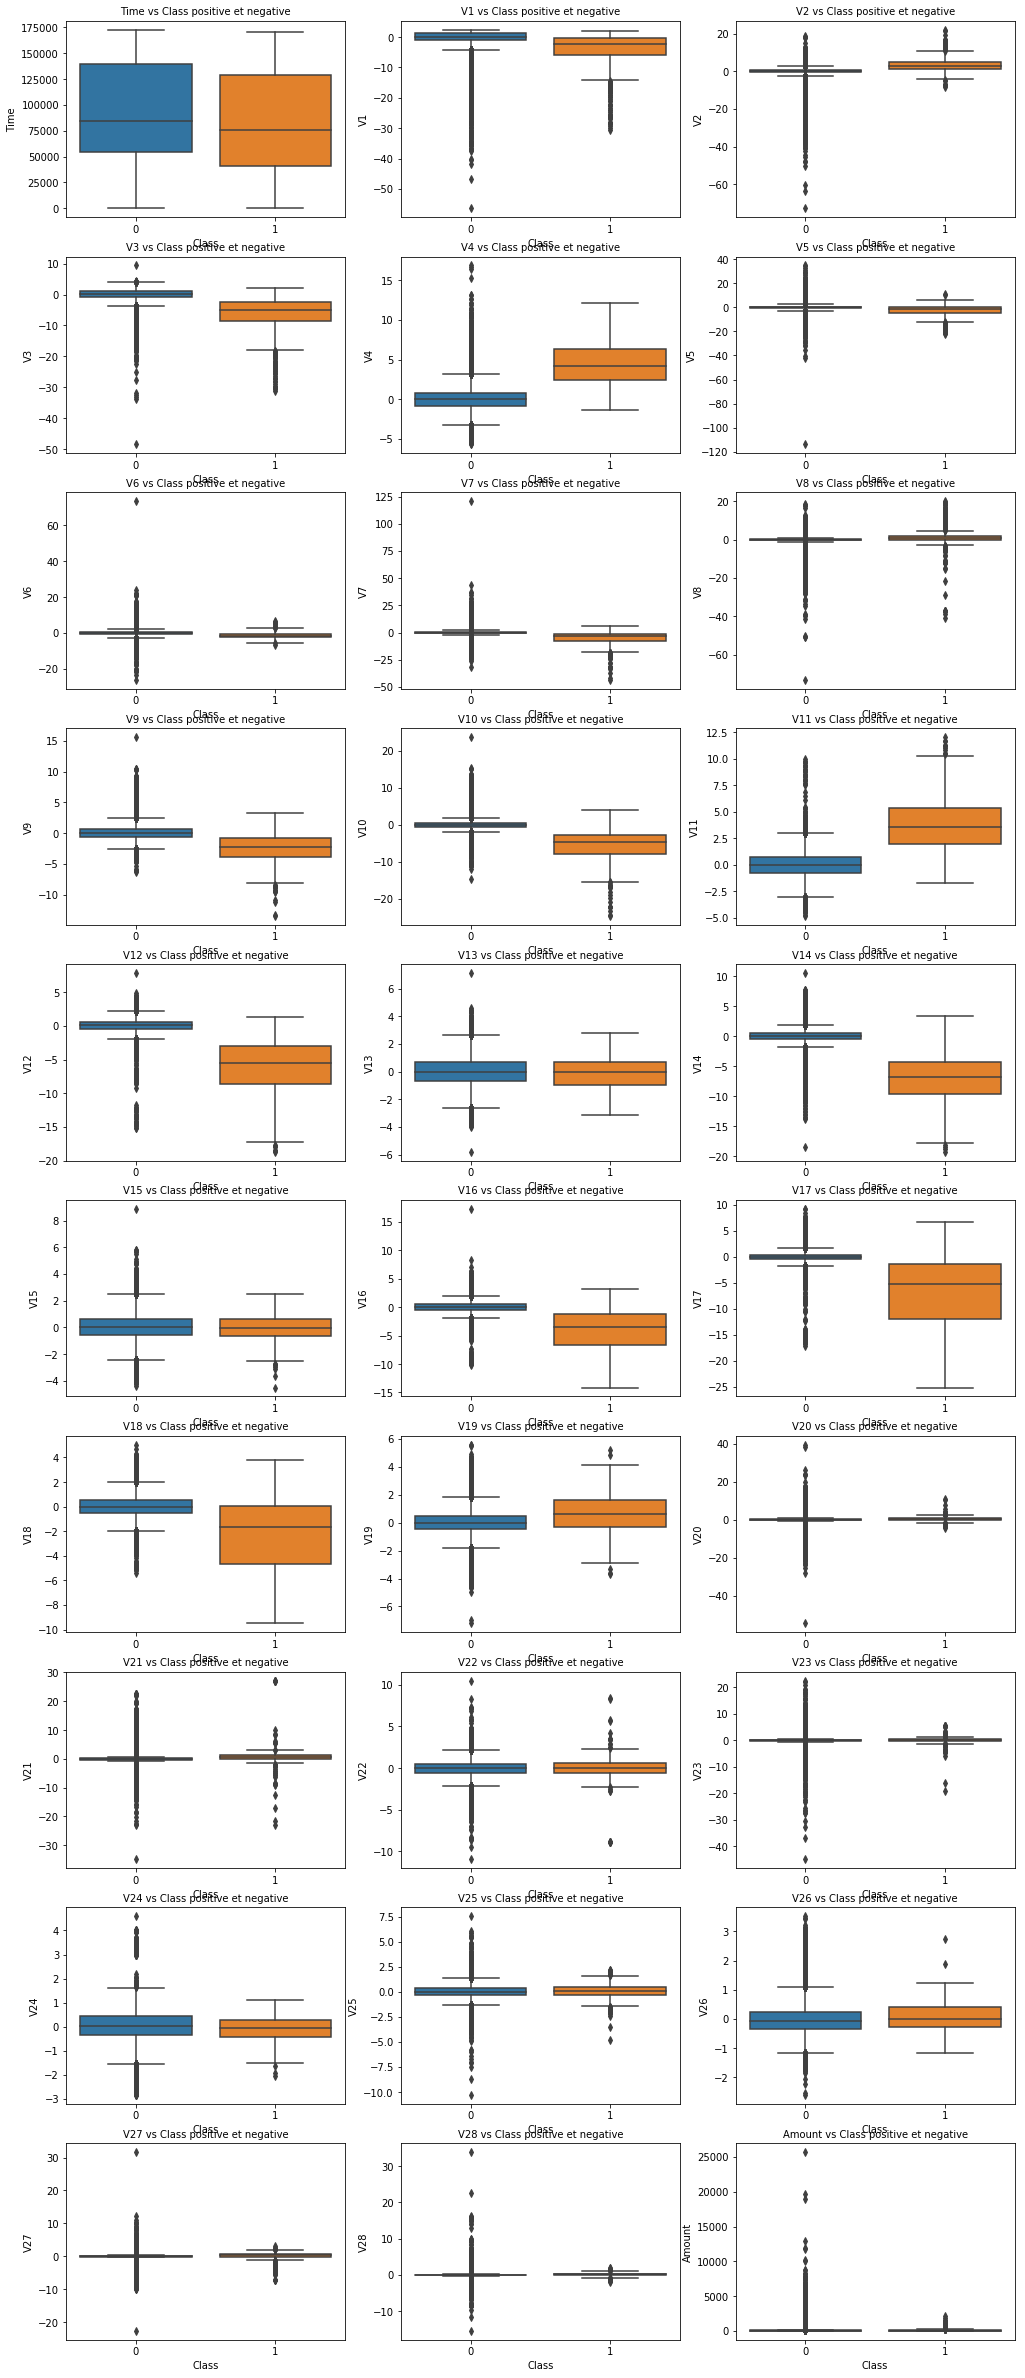

In [30]:
box_plot(creditcard)

In [124]:
def corplot(df):
    corr = df.corr() # calculate correlations
    d = 2 - 2*corr.values # convert to normalized euclidean distances

    # creation of pairwise distance list (comme pdist)
    res = []
    for i in range(d.shape[0]):
        for j in range(i+1, d.shape[1]):
            res.append(d[i,j])

    # creation of the dendrogram
    Z = hierarchy.linkage(d, method='ward')
    dn = hierarchy.dendrogram(Z,no_plot=True)
    idx = dn['leaves']
    
    # reorder rows and columns according to the order of the leaves
    cor = corr.copy()
    cor = cor.iloc[:, idx]
    cor = cor.iloc[idx,:]
    
    # delete the values under the diagonal
#     for i in range(cor.shape[0]):
#         for j in range(i+1):
#             cor.iloc[i,j] = np.nan
    

    ax = sns.heatmap(cor, annot=True, fmt='.1f', cmap='seismic')
    # adjust ticks (problem on windows)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

### Correlation entre variable

La figure représente la valeur des corrélations entre chaque variable deux à deux. On peut voir que la variable Amount représentant le montant de la transaction a une corrélation positive importante avec les variables v7 et v20, et une corrélation négative avec v2 et v5, la variable Class représentant la réponse fraude ou non fraude à une corrélation négative un peu importante avec les variables v14, v12 et v17 et la variable Time a une corrélation négative importante avec le variable v3.

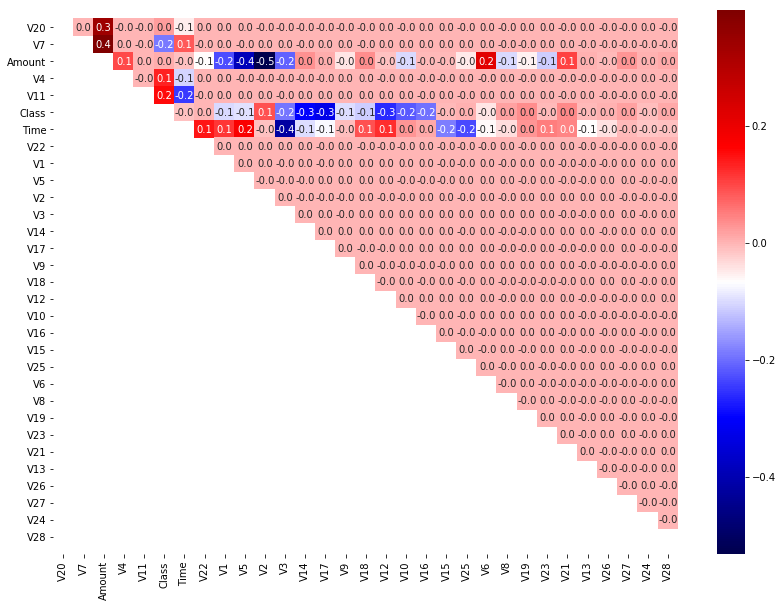

In [130]:
plt.figure(figsize=(14,10))
corplot(creditcard)

# Réduction de Dimension
Étant donne la taille du jeu de données(284 807, 31) les algorithmes de réduction de dimension prend beaucoup de temps durant leurs exécutions, pour diminuer ce temps nous avons sélectionné au hasard 10% du jeu de données pour cette étape de réduction de dimension afin de voir la séparabilité des deux classes. les algorithmes utilisés sont: 

- LLE
- TSNE
- ISOMAP
- UMAP
- PCA

Les résultats obtenus avec chaque méthode sont different en matière d'affichage mais on peut voir sur le plot de chaque méthode que les observations de la class fraude sont dispersé au milieu des données de la class non-fraude. On peut donc dire que les méthodes de classification linéaire n'auront pas une bonne prediction que les autres méthodes non linéaires.

In [9]:
subcreditcard = creditcard.sample(frac=0.1,random_state=0)
print(subcreditcard.shape)
Counter(subcreditcard.Class).items()

(28481, 31)


dict_items([(0, 28426), (1, 55)])

In [86]:
# LLE
lle = LocallyLinearEmbedding(n_components=2).fit_transform(subcreditcard)
joblib.dump(lle,'./input/lle.joblib')

['./input/lle.joblib']

In [87]:
# TSNE
tsne = TSNE(n_components=2).fit_transform(subcreditcard)
joblib.dump(tsne,'./input/tsne.joblib')

['./input/tsne.joblib']

In [88]:
# ISOMAP
iso = Isomap(n_components=2).fit_transform(subcreditcard)
joblib.dump(iso,'./input/iso.joblib')

['./input/iso.joblib']

In [89]:
# PCA
pca = PCA(n_components=2).fit_transform(subcreditcard)
joblib.dump(pca,'./input/pca.joblib')

['./input/pca.joblib']

In [90]:
# UMAP
import warnings
warnings.filterwarnings('ignore')
umap = UMAP(n_components=2,).fit_transform(subcreditcard.values,)
joblib.dump(umap,'./input/umap.joblib')

['./input/umap.joblib']

In [119]:
# UMAP with Class specified
import warnings
warnings.filterwarnings('ignore')
umap_1 = UMAP(n_components=2,).fit_transform(subcreditcard.drop("Class",axis=1).values,subcreditcard.Class.values)
joblib.dump(umap_1,'./input/umap_1.joblib')

['./input/umap_1.joblib']

In [11]:
def dimReduction(data):
    plt.figure(figsize=(12,12))
    colors= ['green' if l == 0 else 'red' for l in data.Class]
    colors = np.array(colors)
    idx = np.array(colors) == 'red'
    
    ax1 = plt.subplot(3,2,1)
    lle = joblib.load('./input/lle.joblib')
    ax1.scatter(lle[:,0], lle[:,1], color=colors)
    ax1.scatter(lle[idx,0], lle[idx,1],color=colors[idx])
    ax1.set_title('reduction avec LLE', fontsize=14)
    ax1.set_xlabel('1 Composent')
    ax1.set_ylabel('2 Composent')
    
    ax2 = plt.subplot(3,2,2)
    tsne = joblib.load('./input/tsne.joblib')
    plt.scatter(tsne[:,0], tsne[:,1], color=colors)
    ax2.scatter(tsne[idx,0], tsne[idx,1],color=colors[idx])
    ax2.set_title('reduction avec TSNE', fontsize=14)
    ax2.set_xlabel('1 Composent')
    ax2.set_ylabel('2 Composent')
    
    ax3 = plt.subplot(3,2,3)
    iso = joblib.load('./input/iso.joblib')
    ax3.scatter(iso[:,0], iso[:,1], color=colors)
    ax3.scatter(iso[idx,0], iso[idx,1],color=colors[idx])
    ax3.set_title('reduction avec Isomap',fontsize=14)
    ax3.set_xlabel('1 Composent')
    ax3.set_ylabel('2 Composent')
    
    ax4 = plt.subplot(3,2,4)
    umap = joblib.load('./input/umap.joblib')
    ax4.scatter(umap[:,0], umap[:,1], color=colors)
    ax4.scatter(umap[idx,0], umap[idx,1],color=colors[idx])
    ax4.set_title('reduction avec Umap',fontsize=14)
    ax4.set_xlabel('1 Composent')
    ax4.set_ylabel('2 Composent')
    
    ax5 = plt.subplot(3,2,5)
    umap_1 = joblib.load('./input/umap_1.joblib')
    ax5.scatter(umap_1[:,0], umap_1[:,1], color=colors)
    ax5.scatter(umap_1[idx,0], umap_1[idx,1],color=colors[idx])
    ax5.set_title('reduction avec Umap et le label',fontsize=14)
    ax5.set_xlabel('1 Composent')
    ax5.set_ylabel('2 Composent')
    
    ax6 = plt.subplot(3,2,6)
    pca = joblib.load('./input/pca.joblib')
    ax6.scatter(pca[:,0],pca[:,1], color=colors)
    ax6.scatter(pca[idx,0], pca[idx,1],color=colors[idx])
    ax6.set_title('reduction avec PCA', fontsize=14)
    ax6.set_xlabel('1 Composent')
    ax6.set_ylabel('2 Composent')
    
    plt.show()


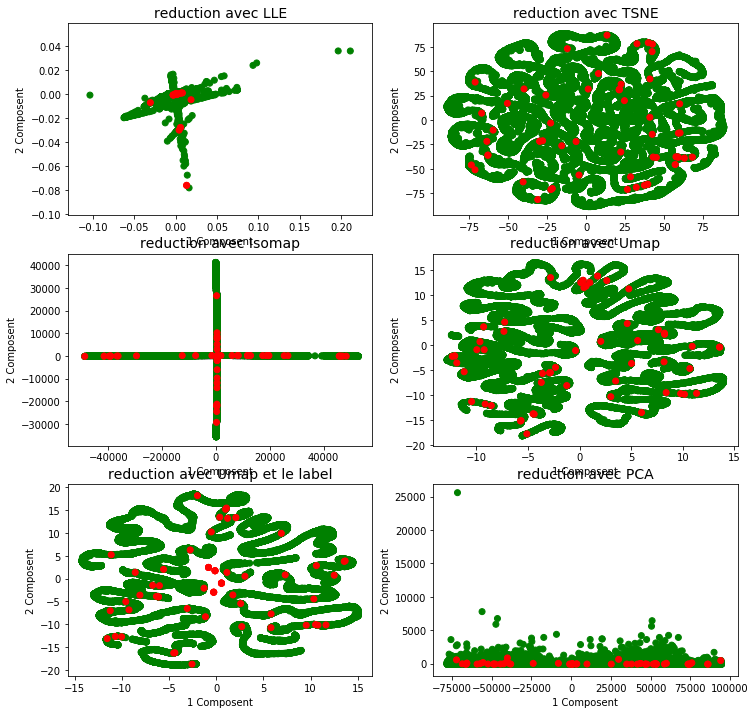

In [12]:
res = dimReduction(subcreditcard)

#   Apprentissage suppervisé

Avec le déséquilibre entre la classe fraud et non fraud nous utiliserons trois solutions différentes pour résoudre le problème du déséquilibre avec les trois méthodes suivantes:
1. SMOTE (from imblearn) une méthode de suréchantillonnage (over-sampling) de la Class avec moins de données
2. RandomUnderSampler (from imblearn) une méthode de sous-échantillonnage (under-sampling) à partir des données et de la variable cible
3. SMOTTEN (from imblearn) une méthode qui combine sur le suréchantillonnage et sous-échantillonnage afin d'équilibrer les classes

Nous utiliserons une validation croisée sur 75% du jeu de données sélectionner par la méthode train test split de sklearn afin de sélectionner le meilleur algorithme parmi ceux proposer. Le 25%% restant servira de données de test sur le modèle obtenu avec le meilleur algorithme.

### Preparation des nouvelles echantillons

In [5]:
X = creditcard.drop('Class', axis=1).values
Y = creditcard.Class.values
validation_size = 0.25
num_fold = 5
seed = 0

In [6]:
# creation of smote sample
X_smote, Y_smote = imos.SMOTE(random_state=0).fit_resample(X, Y)
print(Counter(Y_smote).items())
X_smote_train, X_smote_validation, Y_smote_train, Y_smote_validation = train_test_split(X_smote, Y_smote, test_size=validation_size, random_state=seed)

dict_items([(0, 284315), (1, 284315)])


In [7]:
# creation of RUS sample
X_rus, Y_rus = imus.RandomUnderSampler(random_state=0).fit_resample(X,Y)
print(Counter(Y_rus).items())
X_rus_train, X_rus_validation, Y_rus_train, Y_rus_validation = train_test_split(X_rus, Y_rus, test_size=validation_size, random_state=seed)

dict_items([(0, 492), (1, 492)])


In [8]:
# creation of SMOTTEN sample
X_smotten, Y_smotten = imc.SMOTEENN(random_state=0).fit_resample(X,Y)
print(Counter(Y_smotten).items())
X_smotten_train, X_smotten_validation, Y_smotten_train, Y_smotten_validation = train_test_split(X_smotten, Y_smotten, test_size=validation_size, random_state=seed)

dict_items([(0, 265482), (1, 275801)])


### Comparaison de certain algorithm sur les differents echantillons

In [9]:
# list of different models used 
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('QDA', QuadraticDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(probability=True)))
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))

In [14]:
def compute(models,X,Y,data_name,kfold=None):
    if kfold==None:
        kfold = KFold(n_splits=5, random_state=7)
    
    # train all models on X and Y dataset 
    for name, model in models:
        mean_y = []
        mean_proba = []
        # train model on train data by cross validation and save 
        # - mean auc score 
        # - mean precision
        # - mean recall
        for i, (train_index, test_index) in enumerate(kfold.split(X)):
            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]
            model.fit(X_train, Y_train)
            pred_proba = model.predict_proba(X_test)
            precision, recall, _ = precision_recall_curve(Y_test, pred_proba[:,1])
            mean_y.append(Y_test)
            mean_proba.append(pred_proba[:,1])
            print("1 fold")

        mean_y = np.concatenate(mean_y) 
        mean_proba = np.concatenate(mean_proba)

        precision, recall, _ = precision_recall_curve(mean_y, mean_proba) 
        auc_score = auc(recall,precision)

        result = dict(precis=precision,rec=recall,auc=auc_score)
        # save result 
        joblib.dump(result,'./output/'+data_name+'/'+name+'.joblib')
        print("done with "+ name) # user information on progess

In [15]:
def display_result(data_name,models):
    models_name = []
    for name, _ in models:
        models_name.append(name)
        
    plt.figure(figsize=(20,8))
    ax = plt.subplot(1,2,1)
    ax1 = plt.subplot(1,2,2)
    bar_p = {}
    for name in models_name:
        res = joblib.load('./output/'+data_name+'/'+name+'.joblib')
        lab = name +' AUC=%.4f' % (res['auc'])
        bar_p[name] = res['auc']
        ax.step(res['rec'], res['precis'], label=lab, lw=2)
        
    ax1.bar(range(len(bar_p)), list(bar_p.values()), align='center',tick_label=list(bar_p.keys()))
    ax1.set_ylabel('auc score')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.legend(loc='lower left', fontsize='medium')
    plt.savefig('./output/'+data_name+'res.png')
    plt.figure().tight_layout()
    plt.show()

### RandomUnderSampling

In [45]:
import warnings
warnings.filterwarnings('ignore')

compute(models,X_rus_train,Y_rus_train,'rus')

done with LR
done with LDA
done with QDA
done with KNN
done with CART
done with NB
done with SVM
done with AB
done with GBM
done with RF
done with ET


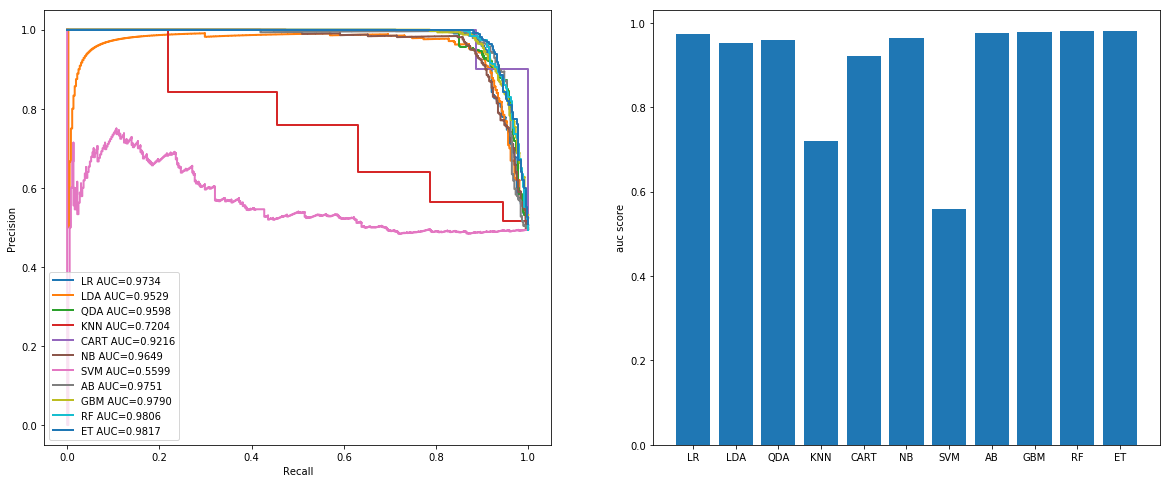

<Figure size 432x288 with 0 Axes>

In [46]:
display_result('rus',models)

### Entrainement et test du meilleur algo

In [25]:
model = ExtraTreesClassifier()
model.fit(X_rus_train, Y_rus_train)
predictions = model.predict(X_rus_validation)
predict_proba = model.predict_proba(X_rus_validation)
precision, recall, _ = precision_recall_curve(Y_rus_validation, predict_proba[:,1]) 
auc_score = auc(recall,precision)
print('Le score AUC : ' ,round(auc_score,4))
print(classification_report(Y_rus_validation, predictions))

Le score AUC :  0.9824
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       119
           1       0.99      0.87      0.93       127

    accuracy                           0.93       246
   macro avg       0.94      0.93      0.93       246
weighted avg       0.94      0.93      0.93       246



### SMOTE

In [29]:
models1 = []
# models.append(('LR', LogisticRegression()))
# models.append(('LDA', LinearDiscriminantAnalysis()))
# models.append(('QDA', QuadraticDiscriminantAnalysis()))
# models.append(('KNN', KNeighborsClassifier()))
# models.append(('CART', DecisionTreeClassifier()))
# models.append(('NB', GaussianNB()))
models1.append(('SVM', SVC(probability=True,max_iter=4)))
# models1.append(('AB', AdaBoostClassifier()))
# models1.append(('GBM', GradientBoostingClassifier()))
models1.append(('RF', RandomForestClassifier(n_estimators=2)))
models1.append(('ET', ExtraTreesClassifier(n_estimators=2)))

In [31]:
models2 = []
models2.append(('LR', LogisticRegression()))
models2.append(('LDA', LinearDiscriminantAnalysis()))
models2.append(('QDA', QuadraticDiscriminantAnalysis()))
models2.append(('KNN', KNeighborsClassifier()))
models2.append(('CART', DecisionTreeClassifier()))
models2.append(('NB', GaussianNB()))
models2.append(('SVM', SVC(probability=True,max_iter=4)))
# models2.append(('AB', AdaBoostClassifier()))
# models2.append(('GBM', GradientBoostingClassifier()))
models2.append(('RF', RandomForestClassifier(n_estimators=2)))
models2.append(('ET', ExtraTreesClassifier(n_estimators=2)))

In [32]:
import warnings
warnings.filterwarnings('ignore')

compute(models1,X_smote_train,Y_smote_train,'smote')

1 fold
1 fold
1 fold
1 fold
1 fold
done with SVM
1 fold
1 fold
1 fold
1 fold
1 fold
done with RF
1 fold
1 fold
1 fold
1 fold
1 fold
done with ET


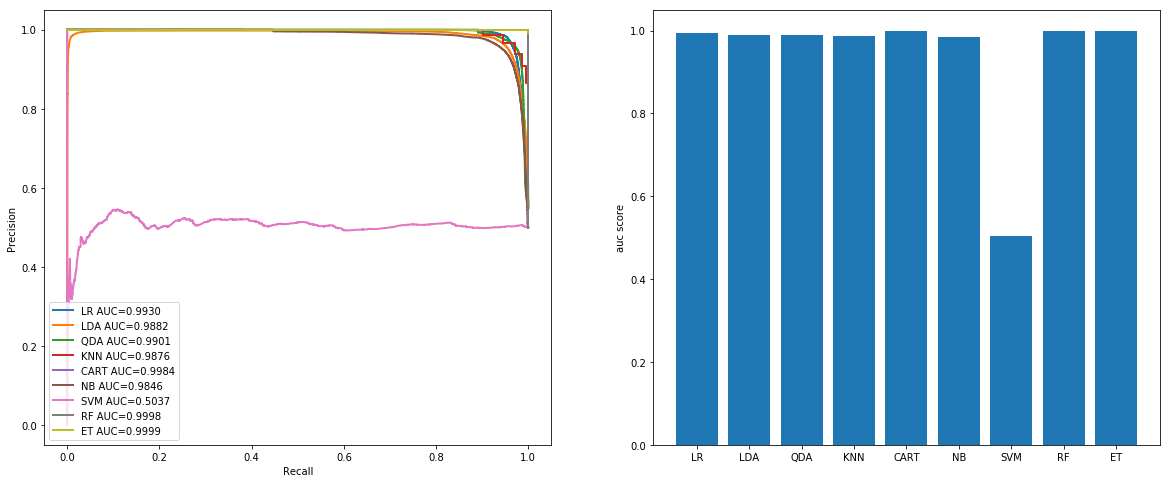

<Figure size 432x288 with 0 Axes>

In [33]:
display_result('smote',models2)

### Entrainement et test du meilleur algo

In [27]:
model = ExtraTreesClassifier(n_estimators=2)
model.fit(X_smote_train, Y_smote_train)
predictions = model.predict(X_smote_validation)
predict_proba = model.predict_proba(X_smote_validation)
precision, recall, _ = precision_recall_curve(Y_smote_validation, predict_proba[:,1]) 
auc_score = auc(recall,precision)
print(auc_score)
print(classification_report(Y_smote_validation, predictions))

0.999857183122112
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70856
           1       1.00      1.00      1.00     71302

    accuracy                           1.00    142158
   macro avg       1.00      1.00      1.00    142158
weighted avg       1.00      1.00      1.00    142158



### SMOTTEN

In [34]:
import warnings
warnings.filterwarnings('ignore')
compute(models1,X_smotten_train,Y_smotten_train,'smotten')

1 fold
1 fold
1 fold
1 fold
1 fold
done with SVM
1 fold
1 fold
1 fold
1 fold
1 fold
done with RF
1 fold
1 fold
1 fold
1 fold
1 fold
done with ET


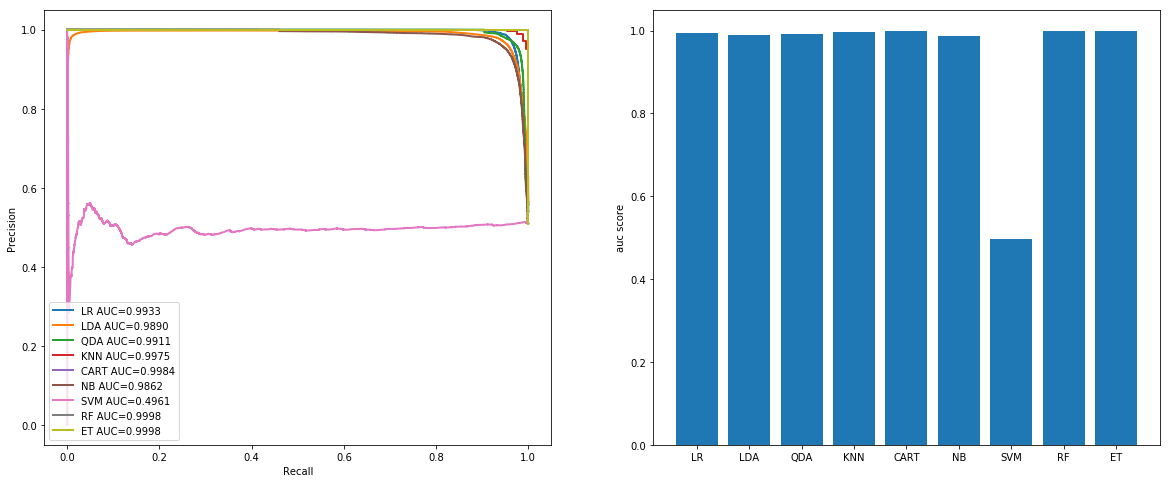

<Figure size 432x288 with 0 Axes>

In [35]:
display_result('smotten',models2)

### Entrainement et test du meilleur algo

In [36]:
model = ExtraTreesClassifier(n_estimators=2)
model.fit(X_smotten_train, Y_smotten_train)
predictions = model.predict(X_smotten_validation)
predict_proba = model.predict_proba(X_smotten_validation)
precision, recall, _ = precision_recall_curve(Y_smotten_validation, predict_proba[:,1]) 
auc_score = auc(recall,precision)
print(auc_score)
print(classification_report(Y_smotten_validation, predictions))

0.9998564562168657
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     66342
           1       1.00      1.00      1.00     68979

    accuracy                           1.00    135321
   macro avg       1.00      1.00      1.00    135321
weighted avg       1.00      1.00      1.00    135321



# Conclusion